#### I used an AWS Instance with GPU. Therefore, before running the notebook, make sure to run this command in terminal:

ubuntu$ conda activate tensorflow_p36

or 

ubuntu$ source activate tensorflow_p36

In [3]:
#Imports
import matplotlib.pyplot as plt
import keras
from keras.applications import VGG16
from keras import models
from keras import layers
from keras.models import Model, Sequential
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import ast
import matplotlib.image as mpimg
import cv2
from scipy.spatial.distance import cosine

Using TensorFlow backend.


## Fashion Hunter - CNN using Pre-Trained VGG16 Architecture

This notebook is for training VGG16 architecture in my dataset and saving the model for future feature extraction.

In [2]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) # using AWS Instance's GPU

In [4]:
base_dir = '/home/ubuntu/clothes'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [92]:
train_size = 0
test_size = 0
val_size = 0 

for folder in os.listdir(train_dir):
    if not folder.startswith("."):
        files = os.listdir(os.path.join(train_dir, folder))
        for file in files:
            if not file.startswith("."):
                train_size += 1
                
for folder in os.listdir(validation_dir):
    if not folder.startswith("."):
        files = os.listdir(os.path.join(validation_dir, folder))
        for file in files:
            if not file.startswith("."):
                val_size += 1
                
for folder in os.listdir(test_dir):
    if not folder.startswith("."):
        files = os.listdir(os.path.join(test_dir, folder))
        for file in files:
            if not file.startswith("."):
                test_size += 1
                
                
print("Train Size = ", train_size)
print("Validation Size = ", val_size)
print("Test Size = ", test_size)
print("Total:" , train_size + val_size + test_size)

Train Size =  21129
Validation Size =  7041
Test Size =  7041
Total: 35211


In [79]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [7]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [8]:
# Adding sequential layers to the convolutional base:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten(name = "features_layer")) #flatten layer used for features extraction later
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
features_layer (Flatten)     (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 16,813,895
Trainable params: 16,813,895
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [11]:
conv_base.trainable = False

In [12]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data augmentation for the train set:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        class_mode="categorical")

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode="categorical")

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 21129 images belonging to 7 classes.


W0909 14:18:24.860940 139652271224576 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0909 14:18:24.986634 139652271224576 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Found 7041 images belonging to 7 classes.
Epoch 1/100
 - 27s - loss: 1.0909 - acc: 0.6640 - val_loss: 0.4930 - val_acc: 0.8280
Epoch 2/100
 - 21s - loss: 0.7401 - acc: 0.7435 - val_loss: 0.4845 - val_acc: 0.8190
Epoch 3/100
 - 22s - loss: 0.6340 - acc: 0.7830 - val_loss: 0.3926 - val_acc: 0.8660
Epoch 4/100
 - 22s - loss: 0.6020 - acc: 0.7945 - val_loss: 0.6394 - val_acc: 0.7950
Epoch 5/100
 - 22s - loss: 0.5833 - acc: 0.8030 - val_loss: 0.4296 - val_acc: 0.8460
Epoch 6/100
 - 21s - loss: 0.5487 - acc: 0.8135 - val_loss: 0.3600 - val_acc: 0.8900
Epoch 7/100
 - 21s - loss: 0.5550 - acc: 0.8070 - val_loss: 0.4292 - val_acc: 0.8480
Epoch 8/100
 - 22s - loss: 0.5535 - acc: 0.8165 - val_loss: 0.4055 - val_acc: 0.8481
Epoch 9/100
 - 22s - loss: 0.5342 - acc: 0.8215 - val_loss: 0.4202 - val_acc: 0.8760
Epoch 10/100
 - 22s - loss: 0.5121 - acc: 0.8270 - val_loss: 0.3670 - val_acc: 0.8900
Epoch 11/100
 - 20s - loss: 0.5075 - acc: 0.8207 - val_loss: 0.3574 - val_acc: 0.8790
Epoch 12/100
 - 19s -

Epoch 96/100
 - 19s - loss: 0.3244 - acc: 0.8925 - val_loss: 0.2800 - val_acc: 0.8980
Epoch 97/100
 - 19s - loss: 0.3916 - acc: 0.8725 - val_loss: 0.2879 - val_acc: 0.9080
Epoch 98/100
 - 19s - loss: 0.3692 - acc: 0.8725 - val_loss: 0.3233 - val_acc: 0.8870
Epoch 99/100
 - 19s - loss: 0.3504 - acc: 0.8805 - val_loss: 0.2842 - val_acc: 0.9001
Epoch 100/100
 - 19s - loss: 0.3626 - acc: 0.8745 - val_loss: 0.2687 - val_acc: 0.9220


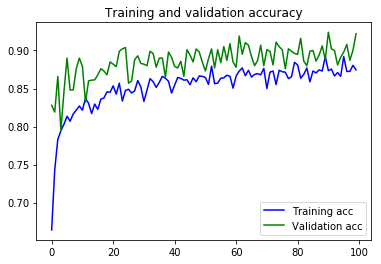

<Figure size 432x288 with 0 Axes>

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc', color = "blue")
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = "green")
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.show()

In [15]:
# Test set score:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 7041 images belonging to 7 classes.
test acc: 0.9149999964237213


In [24]:
model.save('final_model_classifier.h5')